In [5]:
import os
import numpy as np

import time as time

from functools import partial

# Import torch and select GPU
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

# Plot functions
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Radio and convex reg functions
import quantifai as qai
from quantifai.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg

True
1
0
NVIDIA A100-PCIE-40GB


## Set hyperparameters 

In [6]:
# Parameters

# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 15000, "update_iter": 100, "record_iters": False}

# Save param
repo_dir = "./.."

# Test image name from ['M31', 'W28', 'CYN', '3c288']
img_name = "M31"
# Input noise level
input_snr = 30.0

# Define my torch types (CRR requires torch.float32)
myType = torch.float32
myComplexType = torch.complex64

# CRR load parameters
sigma_training = 5
t_model = 5
CRR_dir_name = "./../trained_models/"
# CRR parameters
lmbd = 5e4  # lambda parameter
mu = 20

# Prepare observations 

In [7]:
# Load image and mask
img, mat_mask = qai.helpers.load_imgs(img_name, repo_dir)

# Aliases
x = img
ground_truth = img

torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape(
    (1, 1) + img.shape
)

phi = qai.operators.MaskedFourier_torch(
    shape=img.shape, ratio=0.5, mask=mat_mask, norm="ortho", device=device
)

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Define noise level
eff_sigma = qai.helpers.compute_complex_sigma_noise(y, input_snr)
sigma = eff_sigma * np.sqrt(2)

# Generate noise
rng = np.random.default_rng(seed=0)
n_re = rng.normal(0, eff_sigma, y[y != 0].shape)
n_im = rng.normal(0, eff_sigma, y[y != 0].shape)
# Add noise
y[y != 0] += n_re + 1.0j * n_im

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape(
    (1,) + img.shape
)
# Generate first guess
x_init = torch.abs(phi.adj_op(torch_y))

INSTRUME                                                                         [astropy.io.fits.card]


# Define likelihood and prior

In [8]:
# Define the likelihood
likelihood = qai.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# Lipschitz constant computed automatically by g, stored in g.beta

# Define real prox
prox_op = qai.operators.RealProx_torch()

In [9]:
# Load CRR model
torch.set_grad_enabled(False)
# torch.set_num_threads(4)

exp_name = f"Sigma_{sigma_training}_t_{t_model}/"
if device.type == "cpu":
    CRR_model = utils_cvx_reg.load_model(
        CRR_dir_name + exp_name, "cpu", device_type="cpu"
    )
elif device.type == "cuda":
    CRR_model = utils_cvx_reg.load_model(
        CRR_dir_name + exp_name, "cuda", device_type="gpu"
    )


print(f"Numbers of parameters before prunning: {CRR_model.num_params}")
CRR_model.prune()
print(f"Numbers of parameters after prunning: {CRR_model.num_params}")

--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183


In [10]:
# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
CRR_model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
L_CRR = CRR_model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
# L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")

Lipschitz bound 0.781


# Run optimisation algorithm anc compute the MAP reconstruction

In [11]:
# Compute stepsize
alpha = 0.98 / (likelihood.beta + mu * lmbd * L_CRR)

x_hat = qai.optim.FISTA_CRR_torch(
    x_init=x_init,
    options=options,
    likelihood=likelihood,
    prox_op=prox_op,
    CRR_model=CRR_model,
    alpha=alpha,
    lmbd=lmbd,
    mu=mu,
)

[GD] 0 out of 15000 iterations, tol = 0.017040
[GD] 100 out of 15000 iterations, tol = 0.002369
[GD] 200 out of 15000 iterations, tol = 0.000743
[GD] 300 out of 15000 iterations, tol = 0.000317
[GD] 400 out of 15000 iterations, tol = 0.000190
[GD] 500 out of 15000 iterations, tol = 0.000064
[GD] 600 out of 15000 iterations, tol = 0.000080
[GD] 700 out of 15000 iterations, tol = 0.000037
[GD] 800 out of 15000 iterations, tol = 0.000038
[GD] 900 out of 15000 iterations, tol = 0.000024
[GD] 1000 out of 15000 iterations, tol = 0.000013
[GD] converged in 1005 iterations


# Plot MAP reconstruction

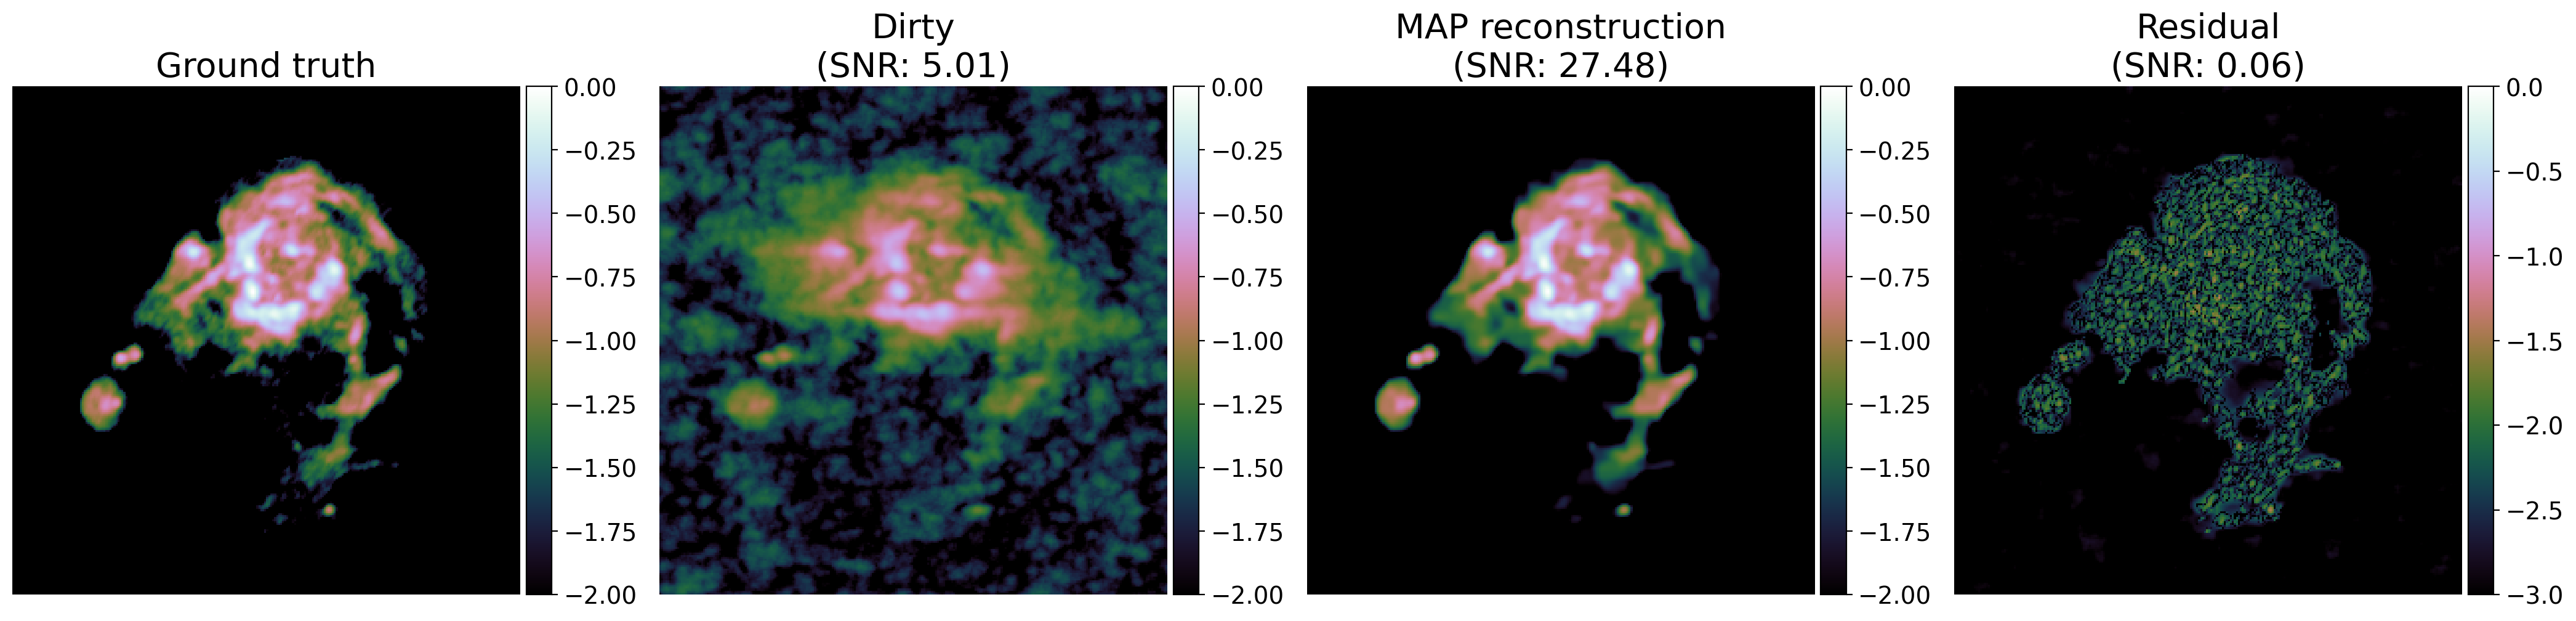

In [12]:
# Convert to numpy
np_x_init = to_numpy(x_init)
x_map = x_hat.clone()
x_gt = np.copy(x)
np_x_gt = np.copy(x)
np_x_map = to_numpy(x_map)


# Need to replace zero values with veery small numbers for the log plots
np_x_gt[np_x_gt == 0] = np.random.rand(np.sum(np_x_gt == 0)) * 1e-7

images = [np_x_gt, np_x_init, np_x_map, np_x_gt - np.abs(np_x_map)]
labels = ["Ground truth", "Dirty", "MAP reconstruction", "Residual"]
vmin_log = [-2.0, -2.0, -2.0, -3.0]

cmap = "cubehelix"

fig, axs = plt.subplots(1, 4, figsize=(26, 8), dpi=200)
for i in range(4):
    im = axs[i].imshow(np.log10(np.abs(images[i])), cmap=cmap, vmax=0, vmin=vmin_log[i])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=14)
    if i > 0:
        stats_str = "\n(SNR: {})".format(
            round(qai.utils.eval_snr(x, images[i]), 2),
        )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=20)
    axs[i].axis("off")
plt.show()

# Compute fast pixel UQ


In [15]:
UQ_options = {
    "alpha_prob": 0.01,  # Alpha for the HPD region
    "wavs_list": ["db8"],  # Wavelet type for UQ maps
    "levels": 4,  # Wavelet levels for UQ maps
    "start_interval": [0, 10],  # Parameter for UQ map bisection
    "iters": 5e2,  # Parameter for UQ map bisection
    "tol": 1e-2,  # Parameter for UQ map bisection
    "thresh_type": "hard",  # Threshold type for fast UQ, options are 'hard' or 'soft'
}

fastpixelUQ = qai.map_uncertainty.FastPixelUQ(
    x_map,
    potential_handle=None,
    UQ_options=UQ_options,
)


fastpixelUQ.set_quantifai_potential_fun_handle(lmbd, mu, CRR_model, likelihood)
(
    modif_img_list,
    GT_modif_img_list,
    SNR_at_lvl_list,
    SNR_at_lvl_map_vs_GT_list,
) = fastpixelUQ.run(x_gt, True)

-----------------------
Updating spline coefficients for the reg cost
 (the gradient-step model is trained and intergration is required to compute the regularization cost)
-----------------------


/disk/xray0/tl3/repos/QuantifAI/quantifai/utils.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(z, device=device, dtype=dtype, requires_grad=False).reshape(


SNR (thresh vs MAP) at lvl 0: 20.090000
SNR (MAP vs GT) at lvl 0: 43.690000
SNR (thresh vs MAP) at lvl 1: 17.080000
SNR (MAP vs GT) at lvl 1: 39.120000
SNR (thresh vs MAP) at lvl 2: 16.550000
SNR (MAP vs GT) at lvl 2: 32.000000
SNR (thresh vs MAP) at lvl 3: 22.430000
SNR (MAP vs GT) at lvl 3: 31.100000
SNR (thresh vs MAP) at lvl 4: 41.220000
SNR (MAP vs GT) at lvl 4: 36.690000


# Plot thresholded MAP saturating the HPD region and errors at all scales

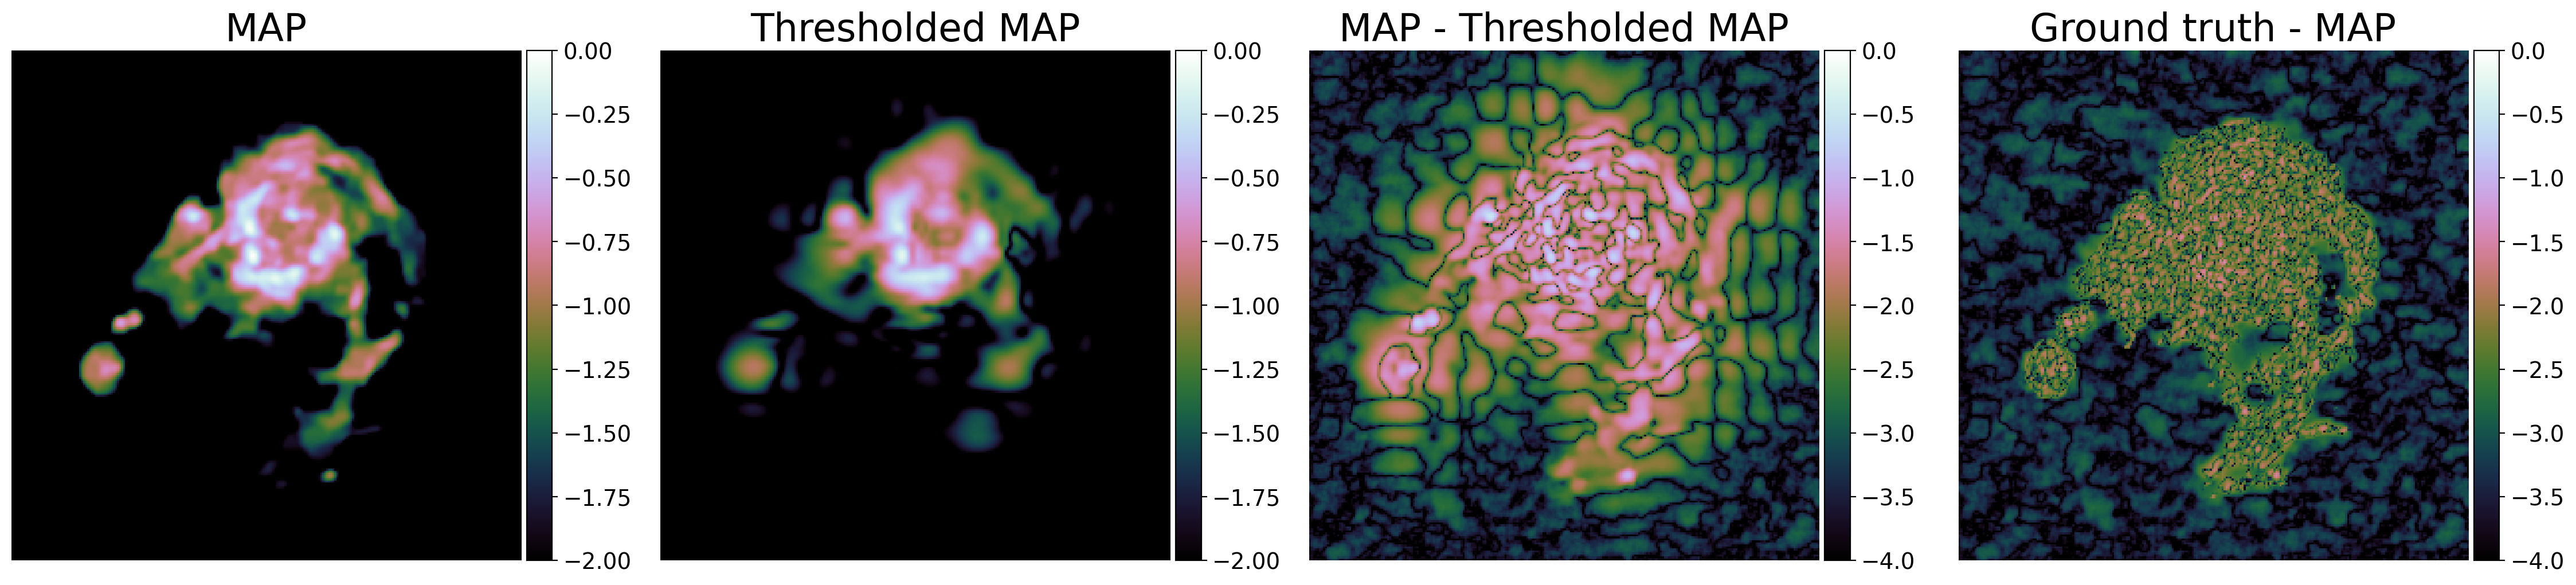

In [19]:
# Get thresholded MAP that saturates the HPD region
thresh_map = to_numpy(fastpixelUQ.thresh_img.clone())


images = [np_x_map, thresh_map, np_x_map - thresh_map, np_x_gt - np_x_map]
labels = ["MAP", "Thresholded MAP", "MAP - Thresholded MAP", "Ground truth - MAP"]
vmin_log = [-2.0, -2.0, -4.0, -4.0]

cmap = "cubehelix"

fig, axs = plt.subplots(1, 4, figsize=(28, 8), dpi=200)
for i in range(4):
    im = axs[i].imshow(np.log10(np.abs(images[i])), cmap=cmap, vmax=0, vmin=vmin_log[i])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=14)
    axs[i].set_title(labels[i], fontsize=24)
    axs[i].axis("off")
plt.show()

# Plot predicted and true error maps as a function of scale

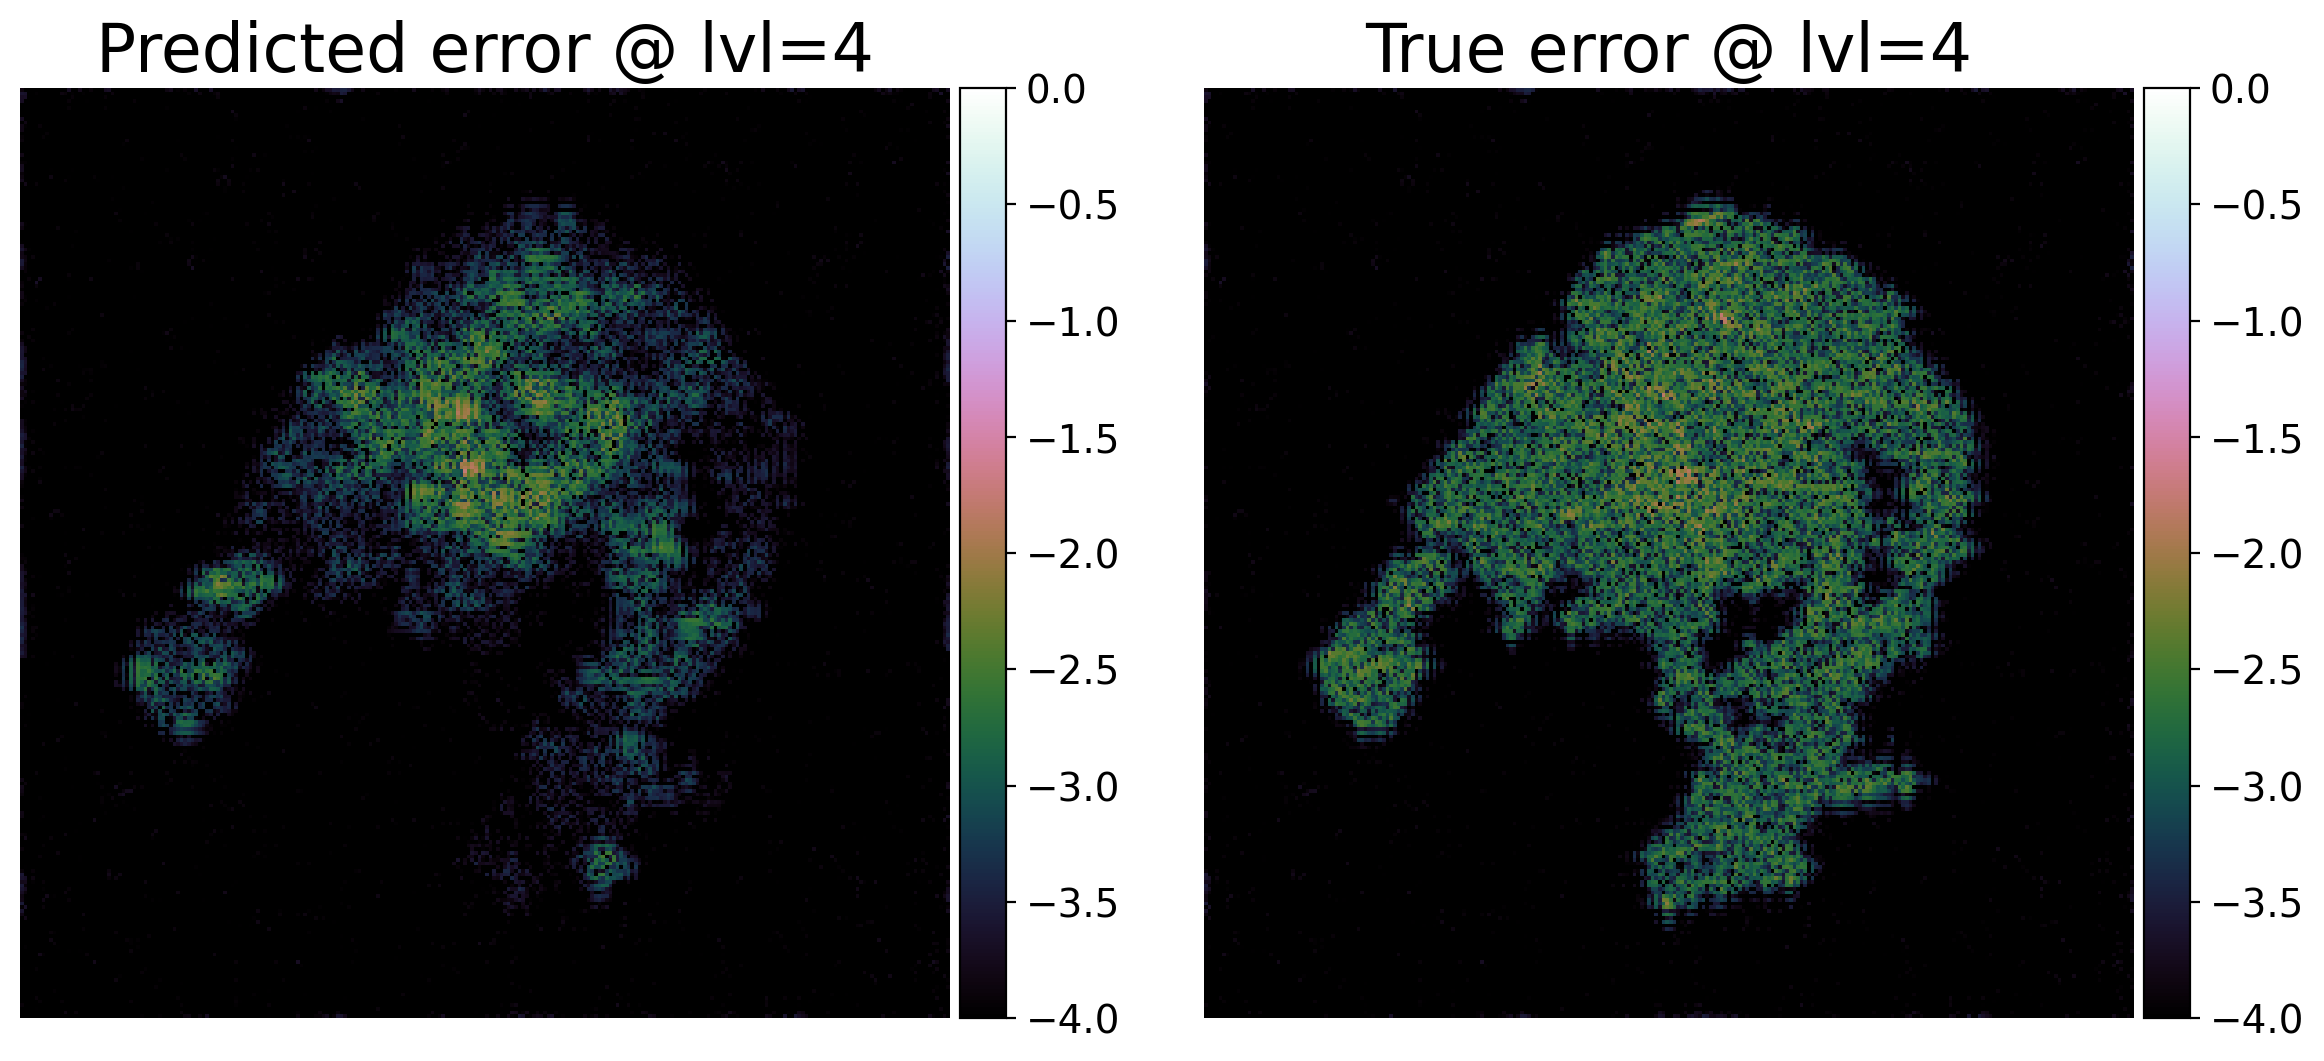

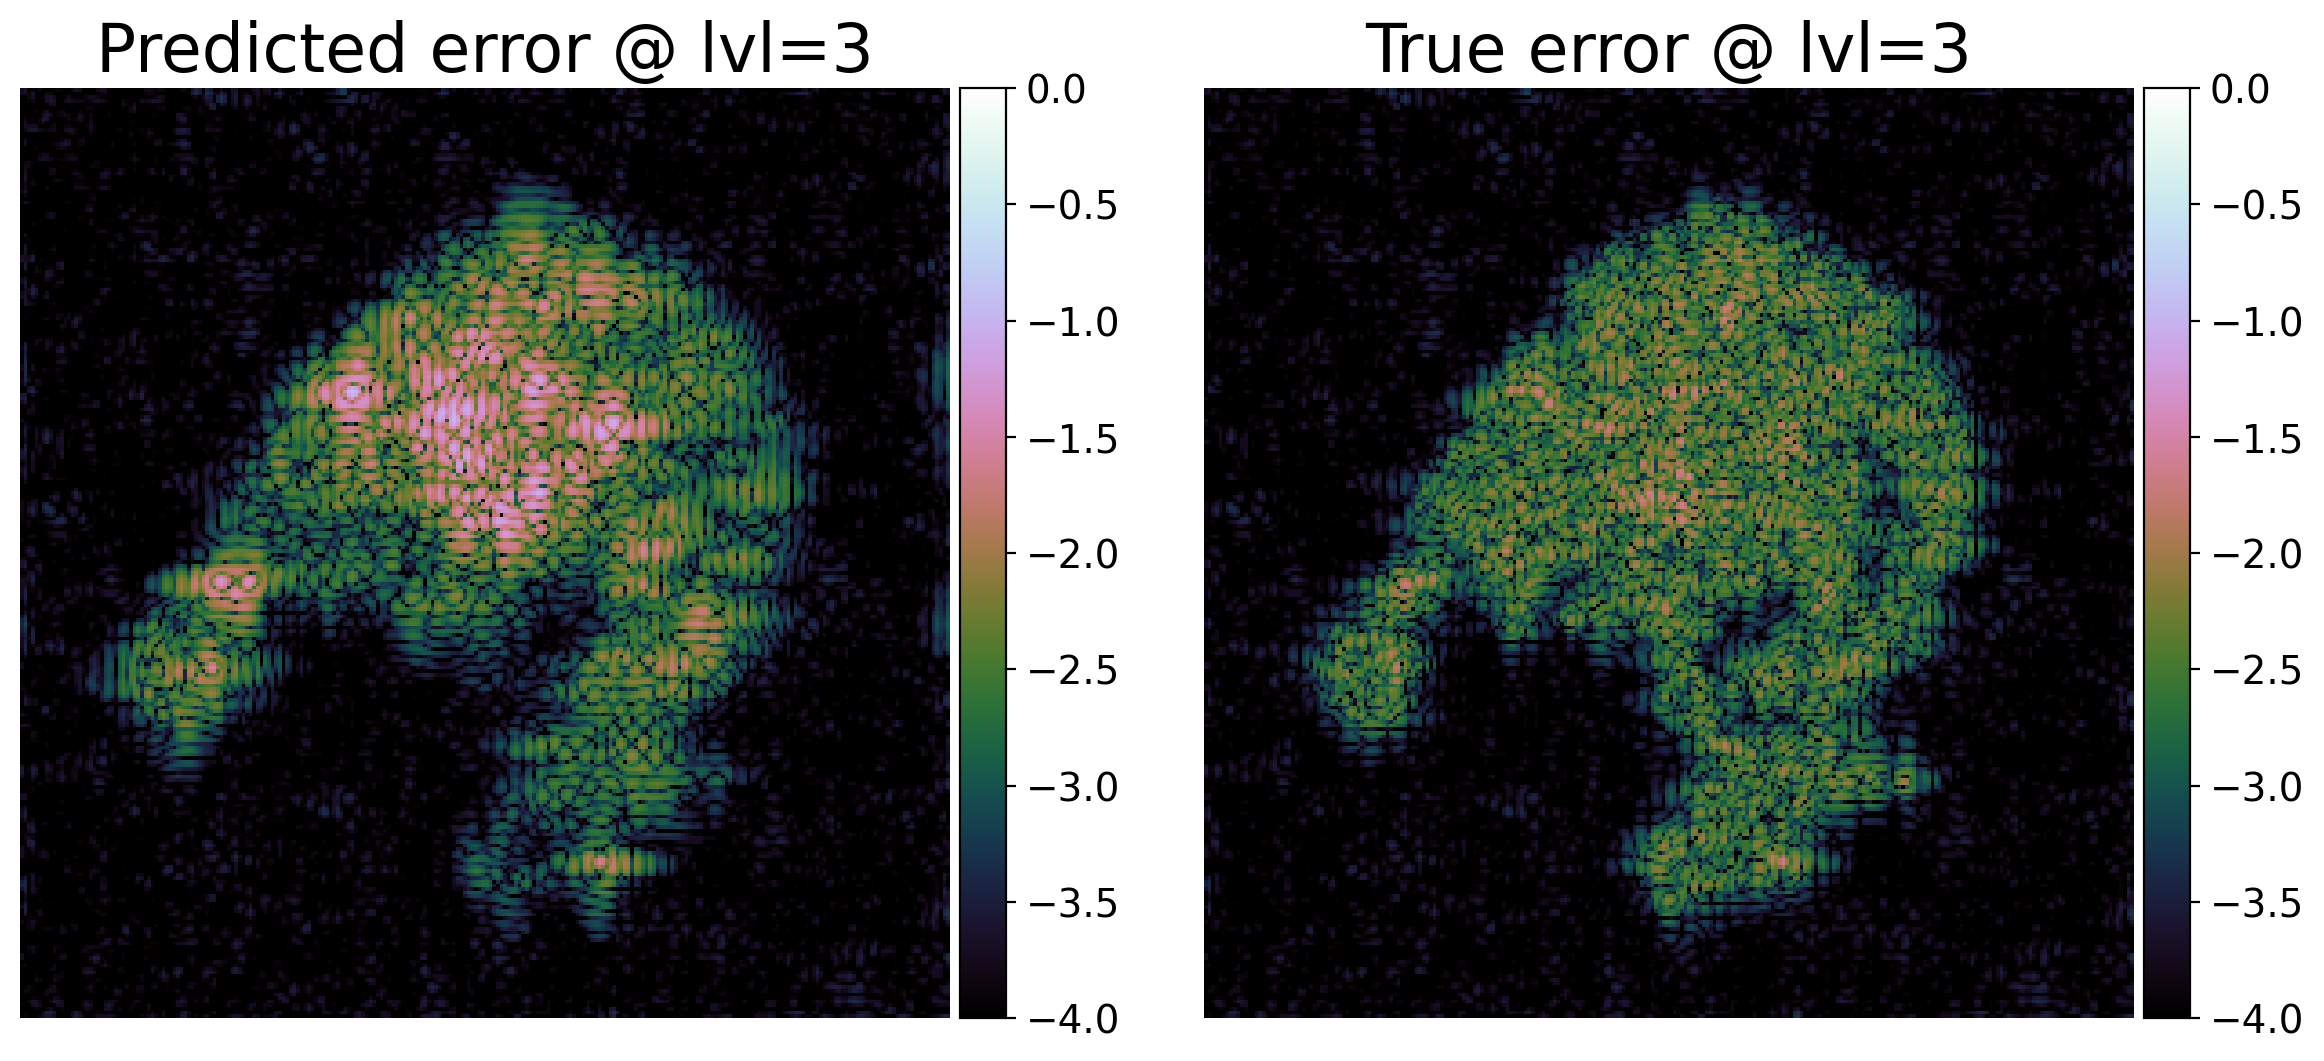

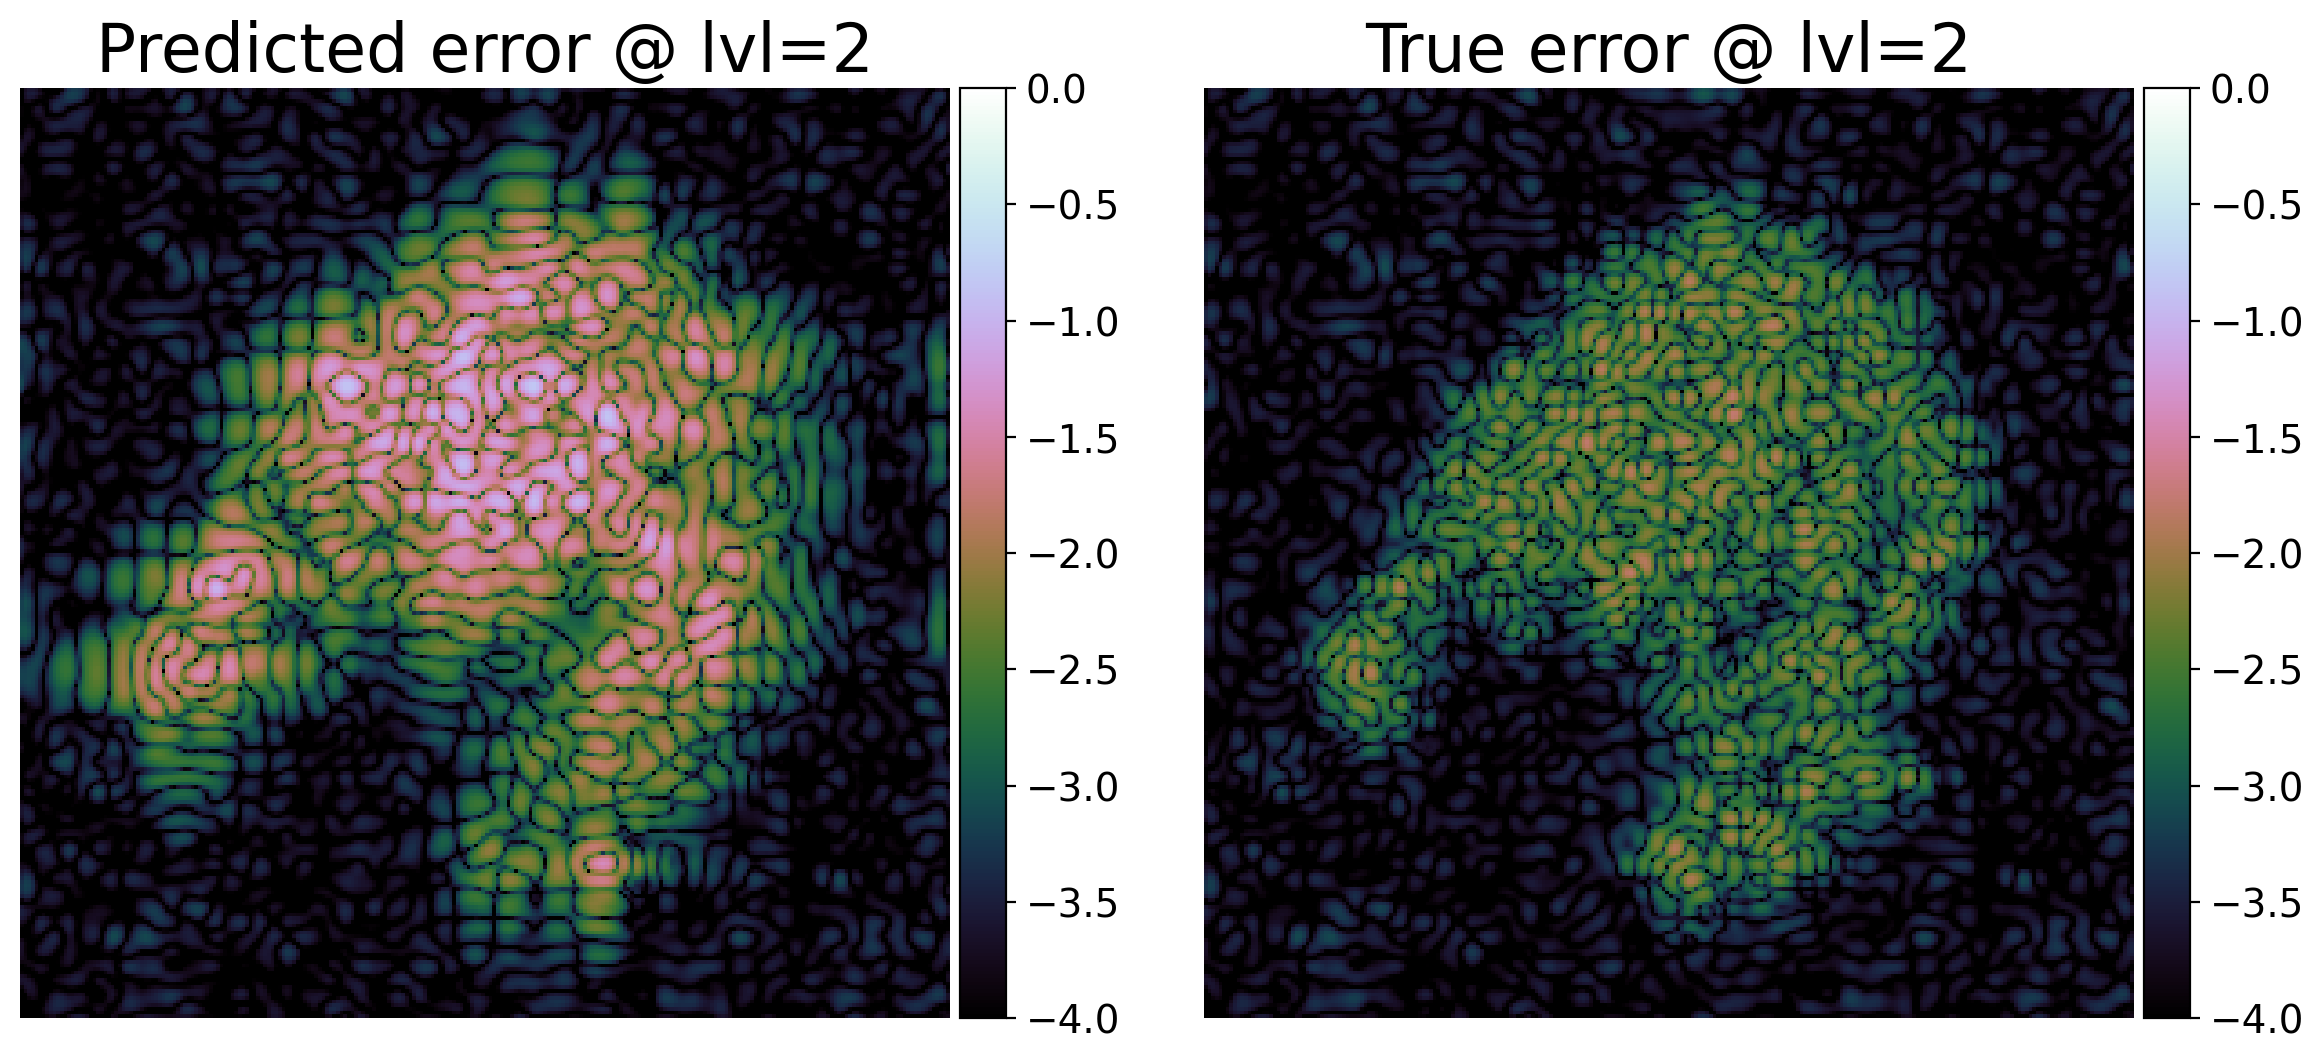

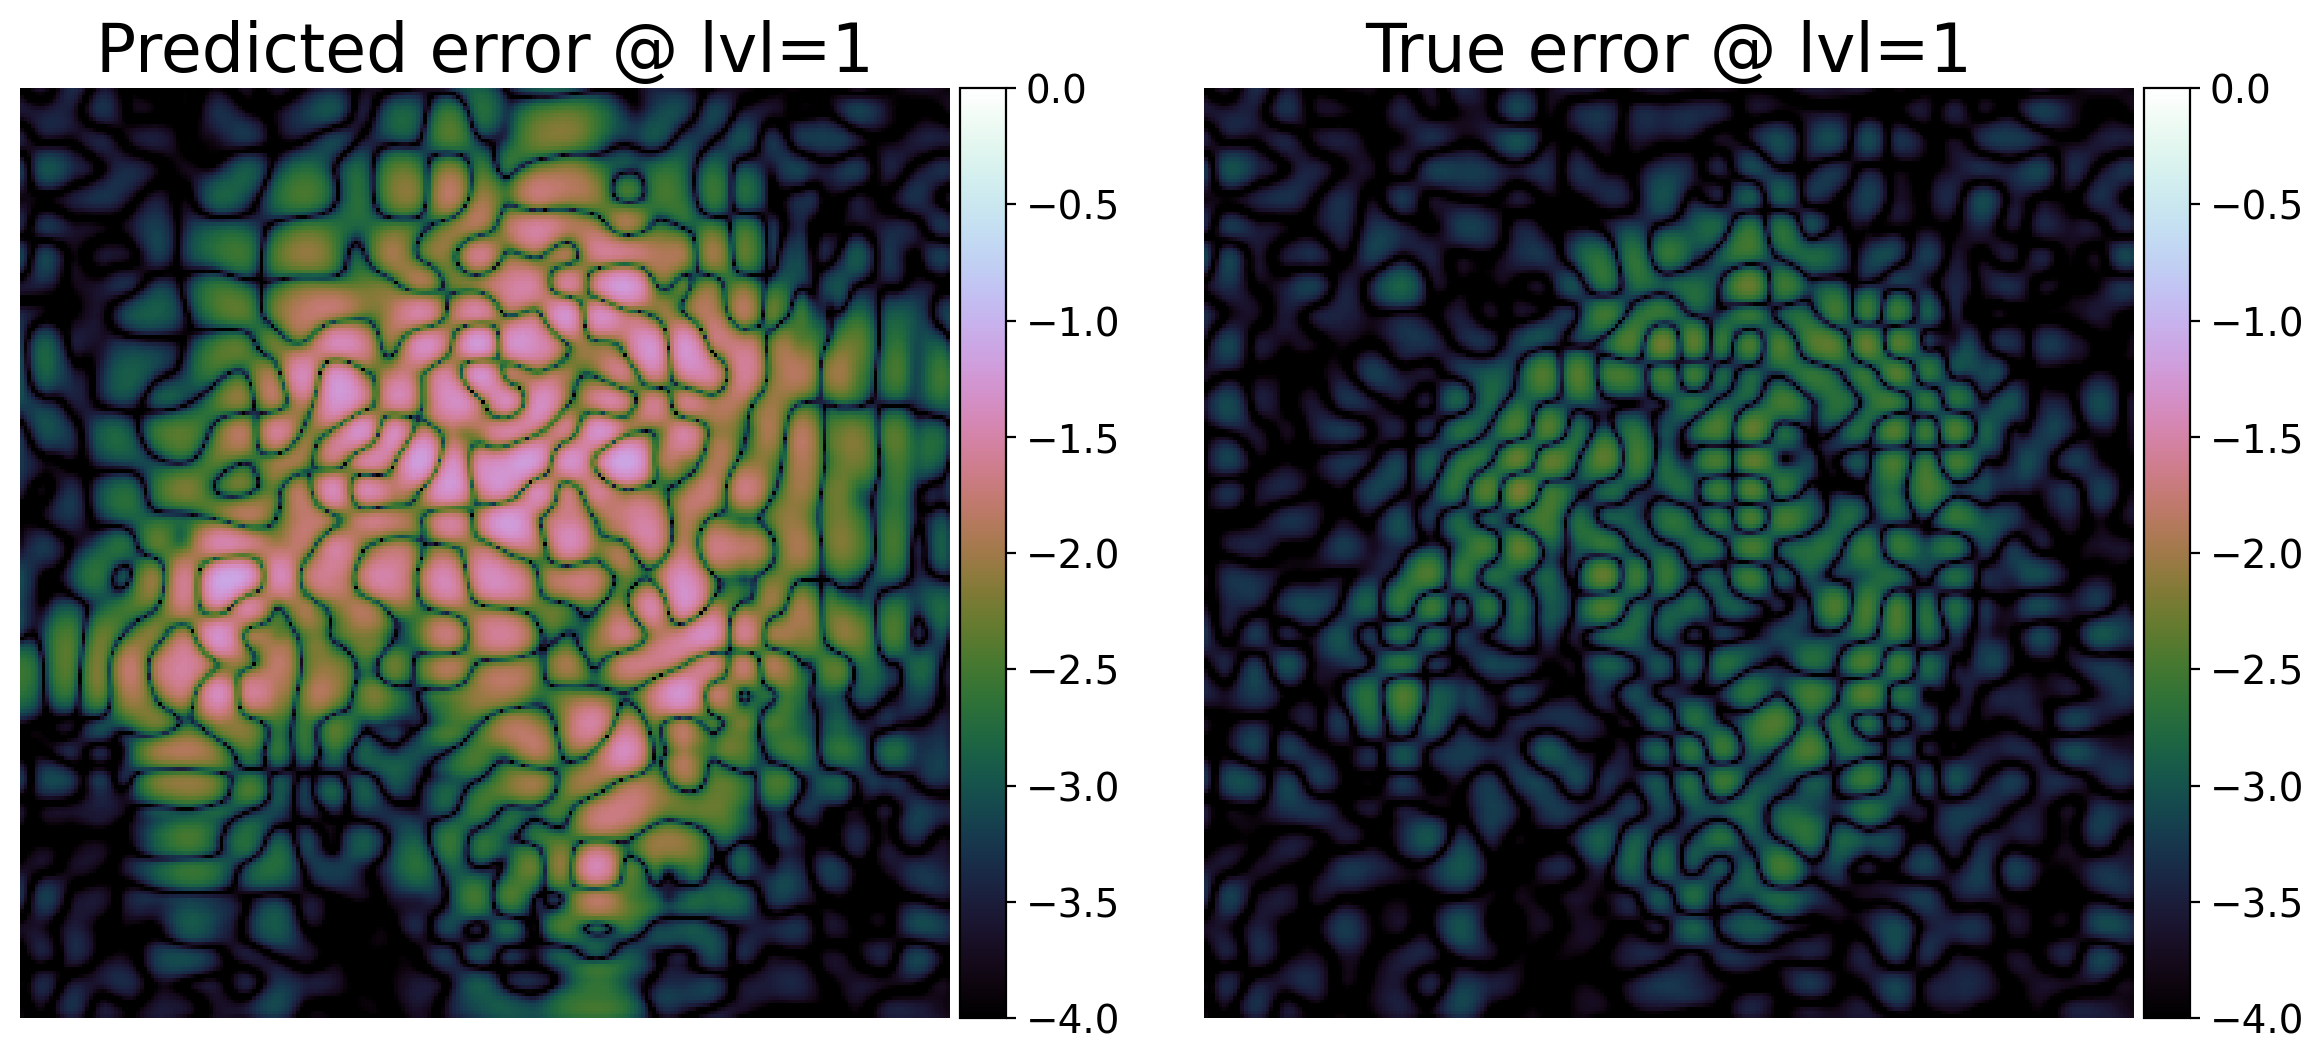

In [23]:
for it in reversed(range(1, len(modif_img_list))):
    images = [np_x_map - modif_img_list[it], np_x_gt - GT_modif_img_list[it]]
    labels = ["Predicted error @ lvl={}".format(it), "True error @ lvl={}".format(it)]
    vmin_log = [-4.0, -4.0]

    cmap = "cubehelix"

    fig, axs = plt.subplots(1, 2, figsize=(14, 8), dpi=200)
    for i in range(2):
        im = axs[i].imshow(
            np.log10(np.abs(images[i])), cmap=cmap, vmax=0, vmin=vmin_log[i]
        )
        divider = make_axes_locatable(axs[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im, cax=cax, orientation="vertical")
        cbar.ax.tick_params(labelsize=14)
        axs[i].set_title(labels[i], fontsize=24)
        axs[i].axis("off")
    plt.show()

In [21]:
to_numpy(x_map).size

65536

In [15]:
# Function handle for the potential
def _fun(_x, CRR_model, mu, lmbd):
    return (lmbd / mu) * CRR_model.cost(mu * _x) + likelihood.fun(_x)


# Evaluation of the potential
fun = partial(_fun, CRR_model=CRR_model, mu=mu, lmbd=lmbd)
# Evaluation of the potential in numpy
fun_np = lambda _x: fun(qai.utils.to_tensor(_x, dtype=myType)).item()

# Compute HPD region bound
N = np_x_map.size
tau_alpha = np.sqrt(16 * np.log(3 / alpha_prob))
gamma_alpha = fun(x_map).item() + tau_alpha * np.sqrt(N) + N

# Define the wavelet dict
# Define the l1 norm with dict psi
Psi = qai.operators.DictionaryWv_torch(wavs_list, levels)
oper2wavelet = qai.operators.Operation2WaveletCoeffs_torch(Psi=Psi)

# Clone MAP estimation and cast type for wavelet operations
torch_map = torch.clone(x_map).to(torch.float64)
torch_x = to_tensor(x_gt).to(torch.float64)

In [16]:
def _potential_to_bisect(thresh, fun_np, oper2wavelet, torch_map):
    thresh_img = oper2wavelet.full_op_threshold_img(
        torch_map, thresh, thresh_type="hard"
    )

    return gamma_alpha - fun_np(thresh_img)


# Evaluation of the potential
potential_to_bisect = partial(
    _potential_to_bisect, fun_np=fun_np, oper2wavelet=oper2wavelet, torch_map=torch_map
)


selected_thresh, bisec_iters = qai.map_uncertainty.bisection_method(
    potential_to_bisect, start_interval, iters, tol, return_iters=True
)
select_thresh_img = oper2wavelet.full_op_threshold_img(torch_map, selected_thresh)

/disk/xray0/tl3/repos/QuantifAI/quantifai/utils.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(z, device=device, dtype=dtype, requires_grad=False).reshape(


In [17]:
modif_img_list = []
GT_modif_img_list = []
SNR_at_lvl_list = []
SNR_at_lvl_map_vs_GT_list = []

for modif_level in range(levels + 1):
    op = lambda x1, x2: x2

    modif_img = oper2wavelet.full_op_two_img(
        torch.clone(torch_map), torch.clone(select_thresh_img), op, level=modif_level
    )
    GT_modif_img = oper2wavelet.full_op_two_img(
        torch.clone(torch_x), torch.clone(torch_map), op, level=modif_level
    )
    print(
        "SNR (thresh vs MAP) at lvl {:d}: {:f}".format(
            modif_level, qai.utils.eval_snr(to_numpy(torch_map), to_numpy(modif_img))
        )
    )
    print(
        "SNR (MAP vs GT) at lvl {:d}: {:f}".format(
            modif_level, qai.utils.eval_snr(to_numpy(torch_x), to_numpy(GT_modif_img))
        )
    )
    modif_img_list.append(to_numpy(modif_img))
    GT_modif_img_list.append(to_numpy(GT_modif_img))
    SNR_at_lvl_list.append(qai.utils.eval_snr(to_numpy(torch_map), to_numpy(modif_img)))
    SNR_at_lvl_map_vs_GT_list.append(
        qai.utils.eval_snr(to_numpy(torch_x), to_numpy(GT_modif_img))
    )

SNR (thresh vs MAP) at lvl 0: 20.090000
SNR (MAP vs GT) at lvl 0: 43.690000
SNR (thresh vs MAP) at lvl 1: 17.080000
SNR (MAP vs GT) at lvl 1: 39.120000
SNR (thresh vs MAP) at lvl 2: 16.550000
SNR (MAP vs GT) at lvl 2: 32.000000
SNR (thresh vs MAP) at lvl 3: 22.430000
SNR (MAP vs GT) at lvl 3: 31.100000
SNR (thresh vs MAP) at lvl 4: 41.220000
SNR (MAP vs GT) at lvl 4: 36.690000


In [4]:
type(torch.float)

torch.dtype